# ***Project 4: Forecasting***

### ***Task 1 : Check for Stationarity and Non-Stationary Properties***

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import scipy.stats as stats

In [2]:
# Loading dataset
df = pd.read_csv('SaYoPillow.csv')

#Renaming columns for better understanding
df.rename(columns={'sr':'snoring_range','rr':'respitory_range','t':'temperature','lm':'limb_movement_rate','bo':'oxygen_in_blood','rem':'rapid_eye_movement','sr.1':'number_of_hours_of_sleep','hr':'heart_rate','sl':'stress_level'}, inplace=True)
df.dropna(inplace=True)

print("Printing first 5 entries of the dataset:\n")
df


Printing first 5 entries of the dataset:



,snoring_range,respitory_range,temperature,limb_movement_rate,oxygen_in_blood,rapid_eye_movement,number_of_hours_of_sleep,heart_rate,stress_level,Date/Time (EST)
0,93.800,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3.0,1/1/2011 1:00
1,91.640,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3.0,1/1/2011 2:00
2,60.000,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1.0,1/1/2011 3:00
3,85.760,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3.0,1/1/2011 4:00
4,48.120,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0.0,1/1/2011 5:00
...,...,...,...,...,...,...,...,...,...,...
625,69.600,20.960,92.960,10.960,90.960,89.80,3.440,62.40,2.0,1/27/2011 2:00
626,48.440,17.376,98.064,6.752,96.376,73.76,8.376,53.44,0.0,1/27/2011 3:00
627,97.504,27.504,86.880,17.752,84.256,101.88,0.000,78.76,4.0,1/27/2011 4:00
628,58.640,19.728,95.728,9.728,94.592,84.32,6.728,59.32,1.0,1/27/2011 5:00


**1.1 Plot the entire time series, that is, both training and test set and check for stationarity.**


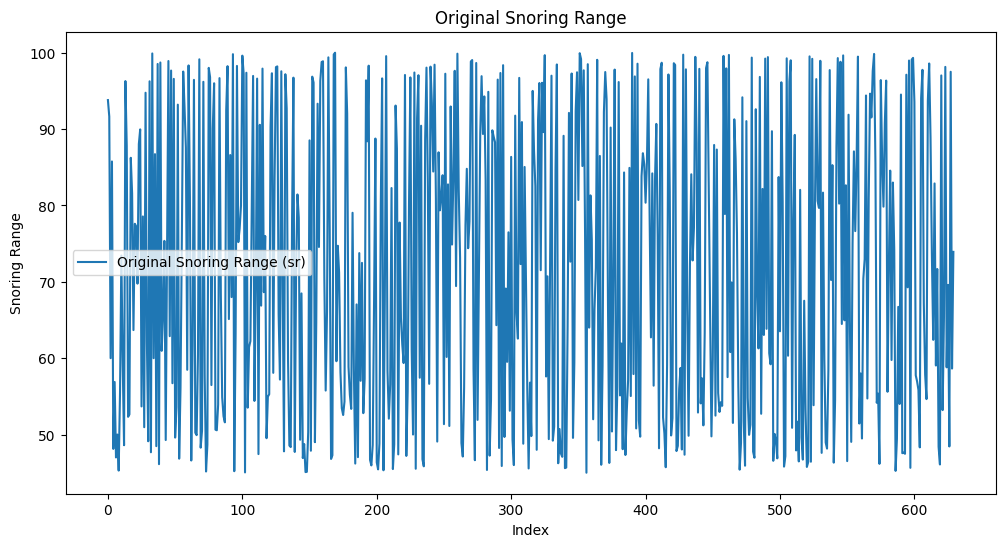

In [25]:
# Add a linear trend to the data
df['sr_with_trend'] = df['snoring_range'] + np.linspace(0, 1, num=len(df)) * 100  # Increase over the series length

# Plotting the time series with the trend
plt.figure(figsize=(12, 6))
plt.plot(df['snoring_range'], label='Original Snoring Range (sr)')
# plt.plot(df['sr_with_trend'], label='Snoring Range with Linear Trend (sr_with_trend)')
plt.title('Original Snoring Range')
plt.xlabel('Index')
plt.ylabel('Snoring Range')
plt.legend()
plt.show()

# Save the new data to CSV if needed
df.to_csv('SaYoPillow(1).csv', index=False)  # Replace with your actual file path


**NOTE:** As we observe visually that the data is stationary I will introduce noise - a strong linear trend to make the data non-stationary 

In [31]:
# function to add non-stationary elements
def make_non_stationary(data):
    n = len(data)
    # Add a stronger linear trend
    trend = np.linspace(0, 1, num=n) * 500  # More pronounced trend
    # Add a periodic component
    seasonal = 100 * np.sin(np.linspace(0, 10 * np.pi, num=n))
    # Increase variance over time
    increasing_variance = np.random.randn(n) * np.linspace(1, 10, num=n)
    
    new_series = data + trend + seasonal + increasing_variance
    return new_series


Index(['snoring_range', 'respitory_range', 'temperature', 'limb_movement_rate',
       'oxygen_in_blood', 'rapid_eye_movement', 'number_of_hours_of_sleep',
       'heart_rate', 'stress_level', 'Date/Time (EST)', 'sr_with_trend',
       'Date/Time', 'non_stationary_data'],
      dtype='object')


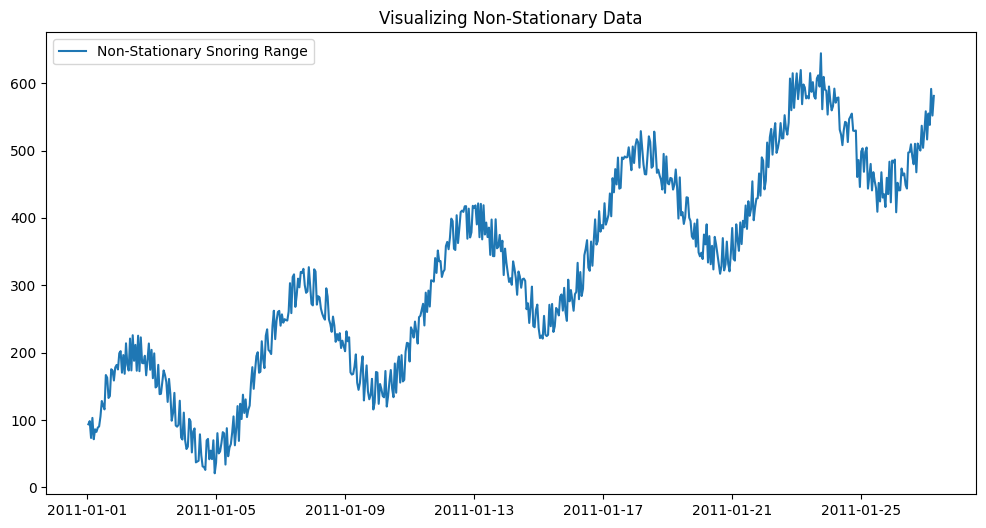

In [49]:
print(df.columns)
df['Date/Time'] = pd.to_datetime(df['Date/Time (EST)']).dropna()
df['non_stationary_data'] = make_non_stationary(df['snoring_range'])
# Plot to visualize
plt.figure(figsize=(12, 6))
plt.plot(df['Date/Time'], df['non_stationary_data'], label='Non-Stationary Snoring Range')
plt.title('Visualizing Non-Stationary Data')
plt.legend()
plt.show()


In [21]:
# # Adding new CSV
# df = pd.read_csv('SaYoPillow(1).csv')

In [67]:
df_selected = df[['non_stationary_data', 'Date/Time (EST)']]

# Splitting the index
split_index = int(len(df) * 0.8)

# Splitting the aggregated data into training and test sets
train = df_selected.iloc[:split_index].reset_index(drop = True)
test = df_selected.iloc[split_index:].reset_index(drop = True)

# train_set = train.reset_index()
# test_set = test.reset_index()

# Displaying the first few values of each set
print("First few values of training set:")
print(train.head())

print("\nFirst few values of test set:")
print(test.head())

First few values of training set:
   non_stationary_data     Date/Time (EST)
0            93.678143 2011-01-01 01:00:00
1            98.382600 2011-01-01 02:00:00
2            73.357591 2011-01-01 03:00:00
3           103.152384 2011-01-01 04:00:00
4            71.476425 2011-01-01 05:00:00

First few values of test set:
   non_stationary_data     Date/Time (EST)
0           455.092231 2011-01-22 01:00:00
1           511.813607 2011-01-22 02:00:00
2           475.313231 2011-01-22 03:00:00
3           519.845082 2011-01-22 04:00:00
4           532.086556 2011-01-22 05:00:00


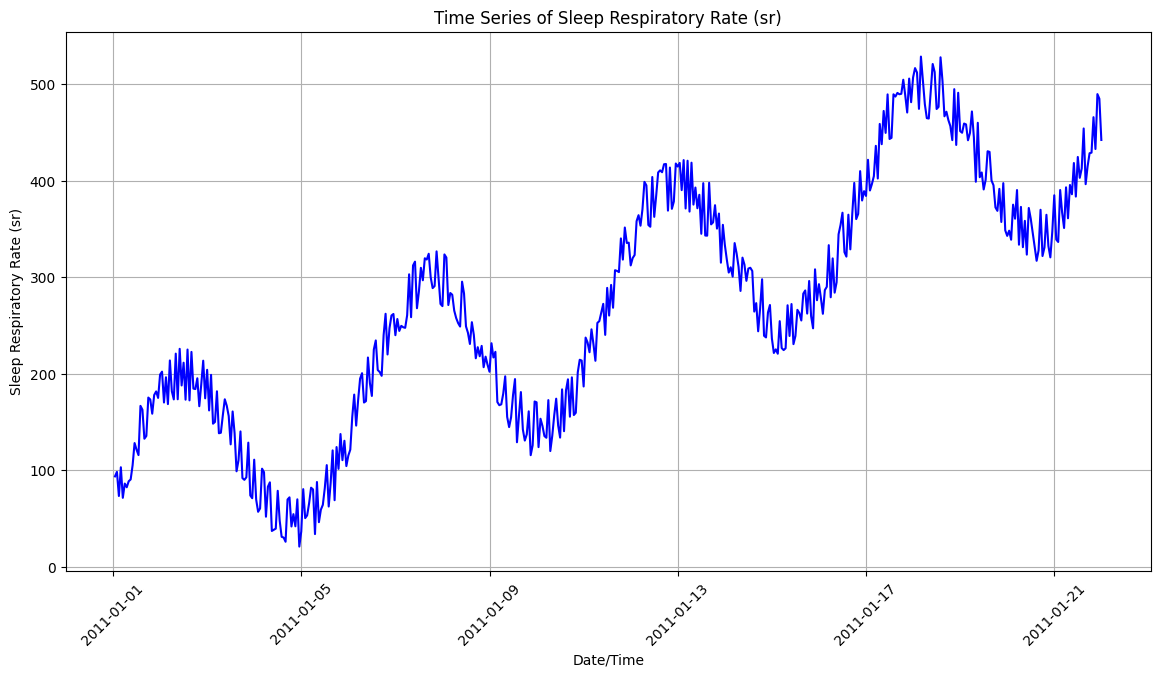

Index(['non_stationary_data', 'Date/Time (EST)'], dtype='object')


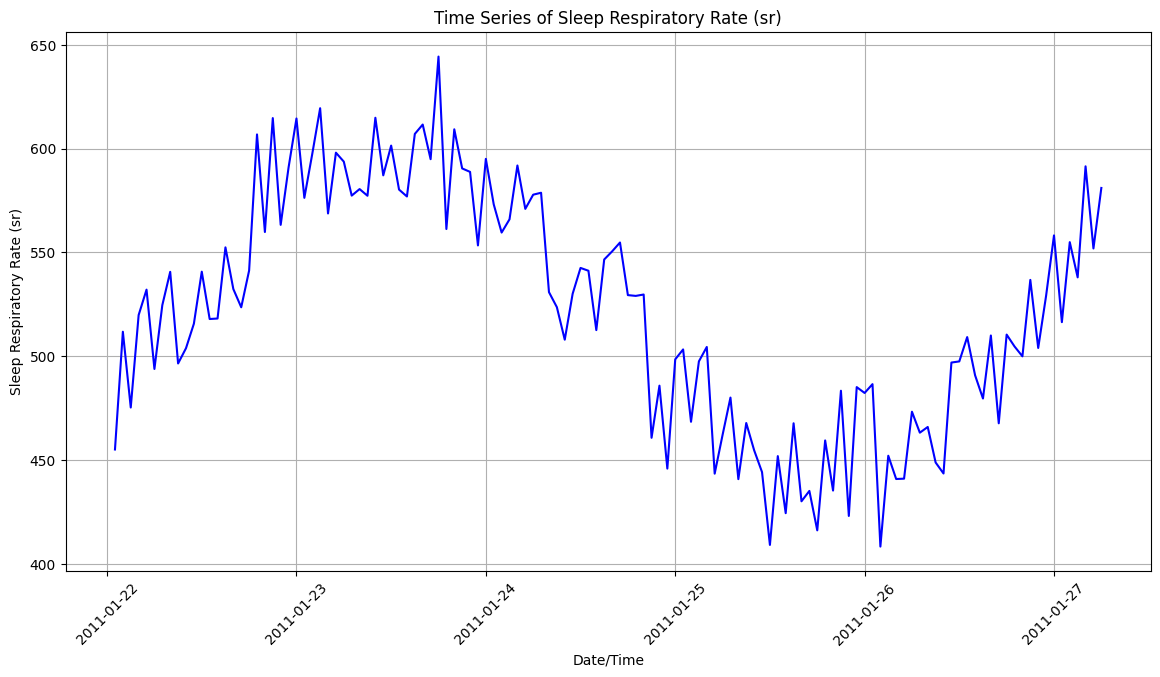

In [68]:
train['Date/Time (EST)'] = pd.to_datetime(train['Date/Time (EST)'])
# For only training set
plt.figure(figsize=(14, 7))
plt.plot(train['Date/Time (EST)'], train['non_stationary_data'], label='Sleep Respiratory Rate (sr) - Training Dataset', color='blue')
plt.title('Time Series of Sleep Respiratory Rate (sr)')
plt.xlabel('Date/Time')
plt.ylabel('Sleep Respiratory Rate (sr)')
plt.xticks(rotation=45)
plt.grid(True)
# plt.legend()
plt.show()
print(train.columns)


train['Date/Time (EST)'] = pd.to_datetime(test['Date/Time (EST)'])
# For only testing set
plt.figure(figsize=(14, 7))
plt.plot(test['Date/Time (EST)'], test['non_stationary_data'], label='Sleep Respiratory Rate (sr) - Testing Dataset', color='blue')
plt.title('Time Series of Sleep Respiratory Rate (sr)')
plt.xlabel('Date/Time')
plt.ylabel('Sleep Respiratory Rate (sr)')
plt.xticks(rotation=45)
plt.grid(True)
# plt.legend()
plt.show()

Checking if the Time Series is Stationary

In [69]:
# Function to perform and print ADF test results
def check_adf(series):
    result = adfuller(series.dropna())  # Dropping NA values to ensure the test runs smoothly
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f'    {key}: {value}')

    if result[1] > 0.05:
        print("The series is non-stationary (p > 0.05).")
    else:
        print("The series is stationary (p <= 0.05).")

# Assuming 'non_stationary_data' is the column you've modified for non-stationarity
check_adf(df['non_stationary_data'])
# print(train.columns)


ADF Statistic: -1.8106003466857594
p-value: 0.37521176043043314
Critical Values:
    1%: -3.4410802944179686
    5%: -2.8662741915097736
    10%: -2.569291225276603
The series is non-stationary (p > 0.05).


WKT, if the p value is less than 0.05 then we reject the null hypothesis and the time series data is stationary. But, if the p-value is larger than 0.05 then we cannot reject the null hypothesis and the time series data would be non-stationary.

In our case the p-value is 0.37 indicating that the time series is **Non-Stationary**

**1.2 If the data set does not appear to be stationary, then check three features for non-stationary time-
series, that is, trend, variance, and seasonality.**


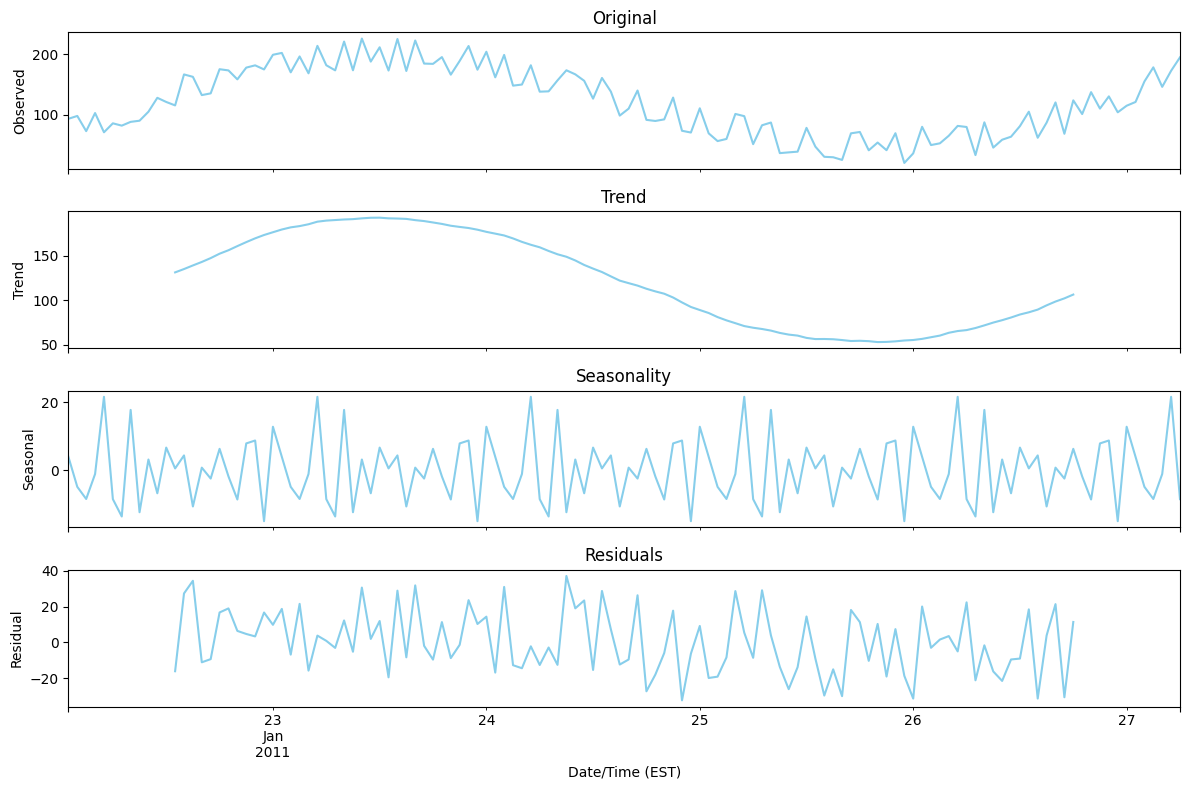

In [141]:
decomposition = seasonal_decompose(train, model='additive')

# Plotting the decomposed time series components
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], legend=False, color='skyblue', title='Original')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='skyblue', title='Trend')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False, color='skyblue', title='Seasonality')
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='skyblue', title='Residuals')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()
# print(train)

**1.3 If the data set does not appear to be stationary, use differencing, seasonal dfferencing, and logarithm
transformation to check stationary properties.**

In [142]:
# Function to perform the ADF test
def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'{key}: {value}')

In [143]:
# 1. Differencing
train_set_diff = train.diff().dropna()
adf_test(train_set_diff, 'Differencing')

ADF Test: Differencing
ADF Statistic: -2.525195433244404
p-value: 0.10946372802338711
1%: -3.487517288664615
5%: -2.8865777180380032
10%: -2.5801239192052012


In [144]:
# 2. Seasonal Differencing (assuming 1 year seasonality)
train_set_seasonal_diff = train.diff(1).dropna() 
adf_test(train_set_seasonal_diff, 'Seasonal Differencing')

ADF Test: Seasonal Differencing
ADF Statistic: -2.525195433244404
p-value: 0.10946372802338711
1%: -3.487517288664615
5%: -2.8865777180380032
10%: -2.5801239192052012


In [145]:
# 3. Logarithmic Transformation
train_set_log = np.log(train).dropna()
adf_test(train_set_log, 'Logarithmic Transformation')

ADF Test: Logarithmic Transformation
ADF Statistic: -1.3922423760475962
p-value: 0.5859895184380215
1%: -3.4885349695076844
5%: -2.887019521656941
10%: -2.5803597920604915


In [146]:
# Differencing the log-transformed data for further stationarity
train_set_log_diff = train_set_log.diff().dropna()
adf_test(train_set_log_diff, 'Differencing Log-Transformed Data')

ADF Test: Differencing Log-Transformed Data
ADF Statistic: -1.5457496949649971
p-value: 0.5107705749463297
1%: -3.490683082754047
5%: -2.8879516565798817
10%: -2.5808574442009578


### ***TASK 2:  Fit a simple moving average model (using the training set)***

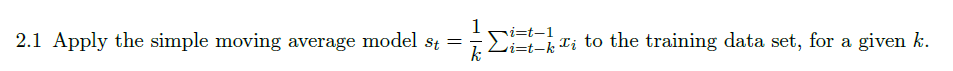

<Figure size 1200x600 with 0 Axes>

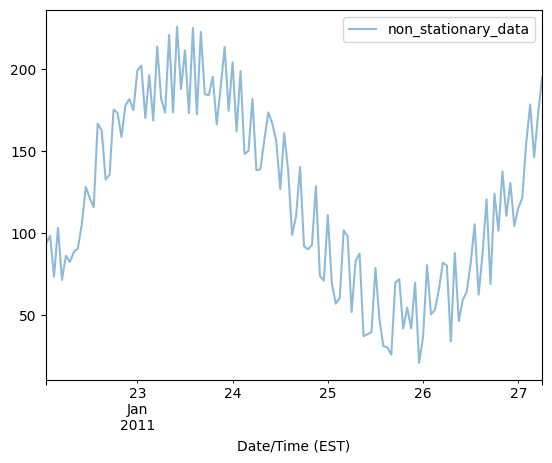

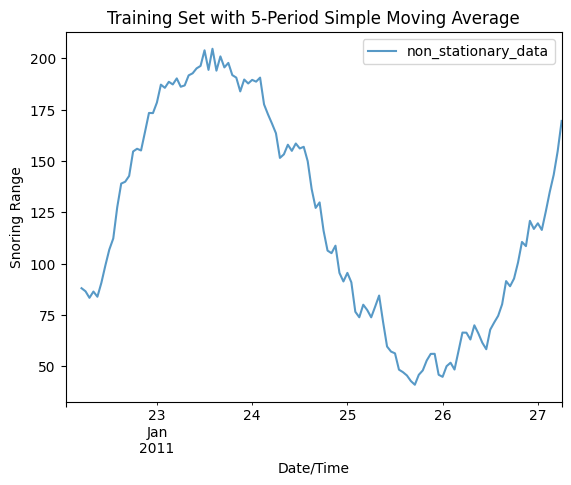

In [149]:
k = 5
train_set_sma = train.rolling(window=k).mean()
plt.figure(figsize=(12, 6))
train.plot(label='Original', alpha=0.5)
train_set_sma.plot(label=f'{k}-Period SMA', alpha=0.75)
plt.title(f'Training Set with {k}-Period Simple Moving Average')
plt.xlabel('Date/Time')
plt.ylabel('Snoring Range')
plt.legend()
plt.show()

**2.2 Calculate the error, i.e., the difference between the predicted and original value in the training data
set, and compute the root mean squared error (RMSE) and Mean Absolute Percentage Error (MAPE)
on slides 29/72.**

In [151]:
train_set_sma_clean = train_set_sma.dropna()
original_clean = train[-len(train_set_sma_clean):]
errors = original_clean - train_set_sma_clean

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_clean, train_set_sma_clean))

# Calculate MAPE
mape = np.mean(np.abs(errors / original_clean)) * 100


print("The RMSE and MAPE values for k = 5:")
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

The RMSE and MAPE values for k = 5:
RMSE: 18.46518054282333
MAPE: 17.420878396507618%


**2.3 Repeat the above two steps by varying k and calculate the RMSE and MAPE.**

Repeating 2.1 for k = 3:


<Figure size 1200x600 with 0 Axes>

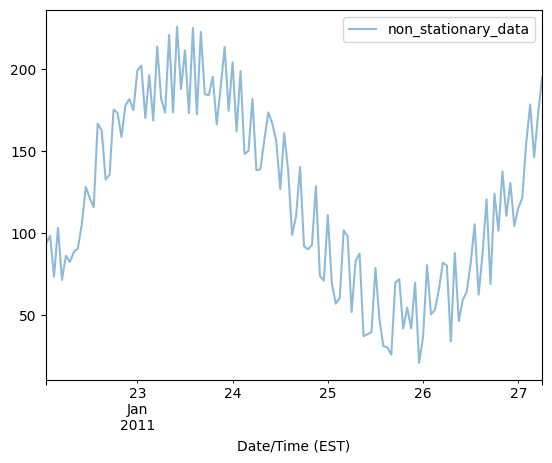

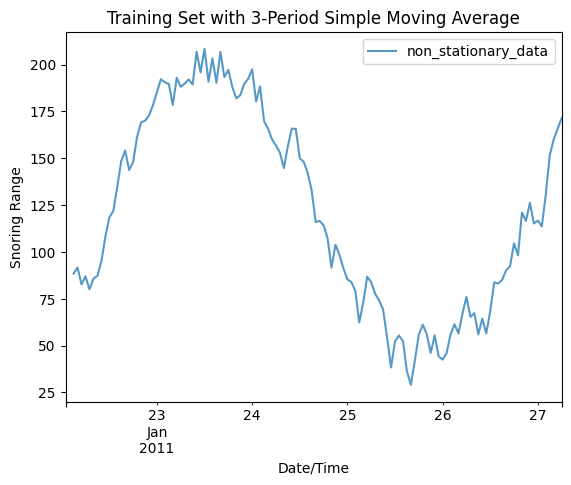

In [152]:
print("Repeating 2.1 for k = 3:")
k = 3

# Apply the simple moving average model
train_set_sma2 = train.rolling(window=k).mean()

# Plotting the original and the SMA series
plt.figure(figsize=(12, 6))
train.plot(label='Original', alpha=0.5)
train_set_sma2.plot(label=f'{k}-Period SMA', alpha=0.75)
plt.title(f'Training Set with {k}-Period Simple Moving Average')
plt.xlabel('Date/Time')
plt.ylabel('Snoring Range')
plt.legend()
plt.show()

In [153]:
train_set_sma_clean = train_set_sma2.dropna()
original_clean = train[-len(train_set_sma_clean):]

# Calculate the errors
errors = original_clean - train_set_sma_clean

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_clean, train_set_sma_clean))

# Calculate MAPE
mape = np.mean(np.abs(errors / original_clean)) * 100
print("Repeating step 2.2 for cahnged K - RMSE and MAPE for K = 3 ")

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

Repeating step 2.2 for cahnged K - RMSE and MAPE for K = 3 
RMSE: 16.704989780251953
MAPE: 15.690199789791906%


**2.4 Plot RMSE and MAPE vs k, respectively. Select k based on the lowest RMSE or MAPE value. For
the best value of k, plot the predicted values against the original values.**

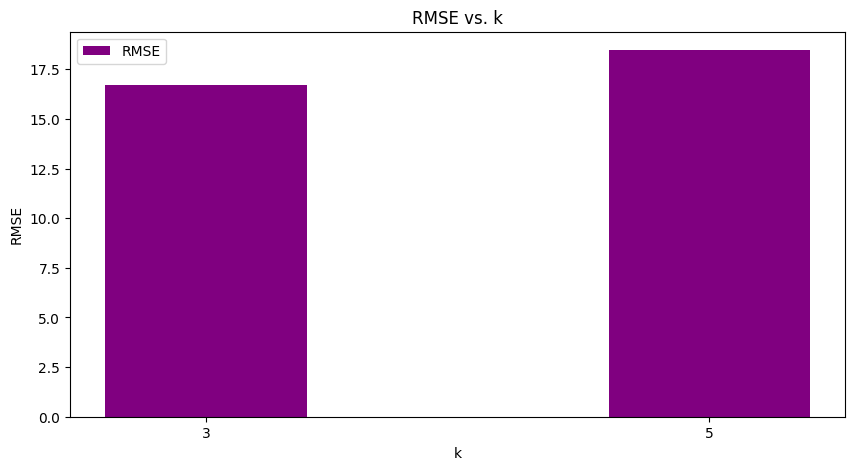

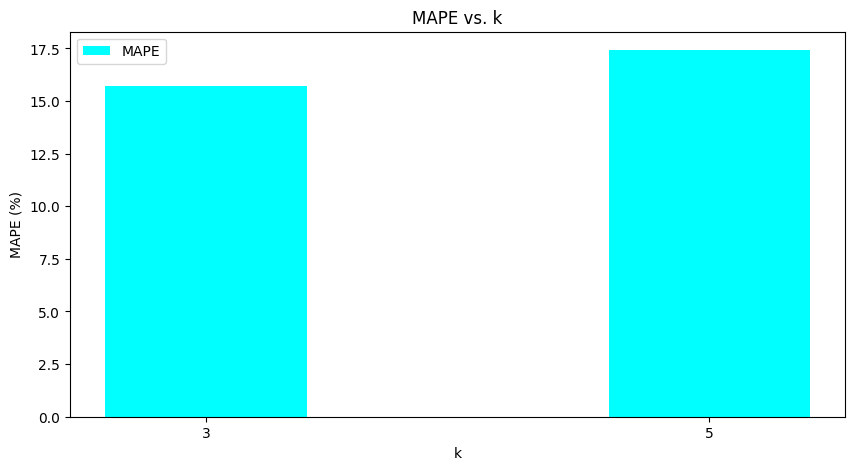

The best k value based on the lowest RMSE/MAPE is as follows:
The best k based on the lowest RMSE is 3.
The best k based on the lowest MAPE is 3.


In [158]:
k_values = [5, 3]
rmse_values = [18.46518054282333, 16.704989780251953]
mape_values = [17.420878396507618, 15.690199789791906]

# Determine the best k based on the lowest RMSE or MAPE
best_k_rmse = k_values[rmse_values.index(min(rmse_values))]
best_k_mape = k_values[mape_values.index(min(mape_values))]

# Plotting RMSE vs k bar chart
plt.figure(figsize=(10, 5))
plt.bar(k_values, rmse_values, color='purple', label='RMSE')
plt.title('RMSE vs. k')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.xticks(k_values)
plt.legend()
plt.show()

# Plotting MAPE vs k highlighting the best k using a vertical bar chart
plt.figure(figsize=(10, 5))
plt.bar(k_values, mape_values, color='cyan', label='MAPE')
plt.title('MAPE vs. k')
plt.xlabel('k')
plt.ylabel('MAPE (%)')
plt.xticks(k_values)
plt.legend()
plt.show()

print("The best k value based on the lowest RMSE/MAPE is as follows:")
print(f"The best k based on the lowest RMSE is {best_k_rmse}.")
print(f"The best k based on the lowest MAPE is {best_k_mape}.")


#### **Since the best k value based on lowest RMSE and MAPE is 3, let's plot the predcited values against the original values for k = 3**

<Figure size 1200x600 with 0 Axes>

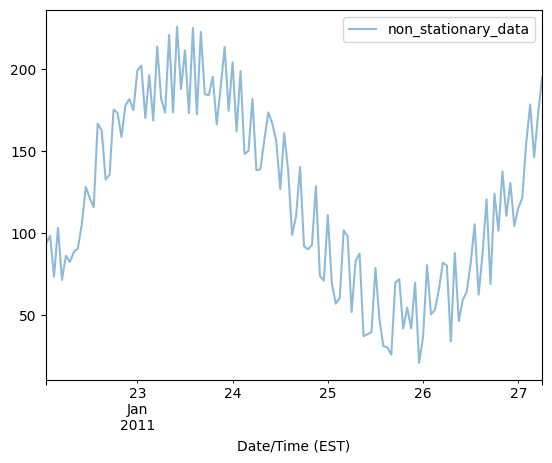

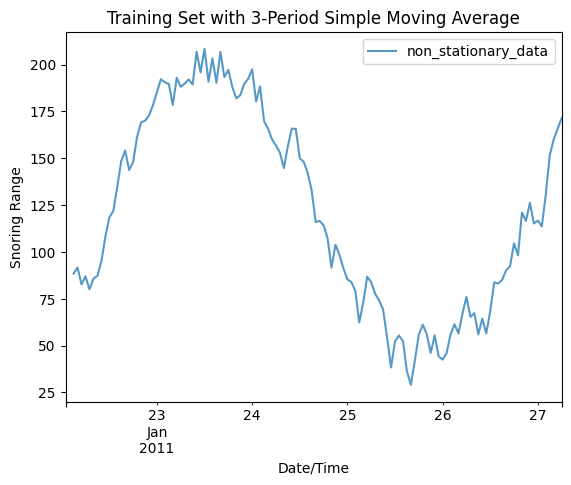

In [159]:
best_k = 3
train_set_sma_best = train.rolling(window=best_k).mean()

# Plotting the original and the best SMA series
plt.figure(figsize=(12, 6))
train.plot(label='Original', alpha=0.5)
train_set_sma_best.plot(label=f'{best_k}-Period SMA', alpha=0.75)
plt.title(f'Training Set with {best_k}-Period Simple Moving Average')
plt.xlabel('Date/Time')
plt.ylabel('Snoring Range')
plt.legend()
plt.show()


**2.5 Comment on your results.**

Analysis of RMSE and MAPE:

- RMSE (Root Mean Square Error) is a measure of the average magnitude of the forecast errors. It squares the errors before averaging them, which tends to give higher weight to larger errors. This means RMSE is especially useful when large errors are particularly undesirable. For your SMA model:
  - The RMSE is lower for ( k = 3 ) than for ( k = 5 ) (16.70 vs 18.47), indicating that the model with ( k = 3 ) generally has smaller forecast errors on average, and thus performs better in terms of predicting the actual values.

- MAPE (Mean Absolute Percentage Error) expresses accuracy as a percentage, and can be more intuitive as it represents errors as a percentage of the actual values. It's particularly useful in contexts where you want to know the size of the error in percentage terms. For your SMA model:
  - The MAPE is also lower for ( k = 3 ) (15.69%) compared to ( k = 5 ) (17.42%). This indicates that the forecasts for ( k = 3 ) are closer to the actual values in percentage terms than those for ( k = 5 ).

Conclusion:
The results suggest that the SMA model with a smaller window size ( k = 3 ) performs better than with ( k = 5 ) in terms of both RMSE and MAPE. This could mean that the model benefits from a more responsive moving average which incorporates less historical data, thus it might be capturing the recent trends more effectively than a larger window which dilutes recent changes by including more historical points.

### ***Task 3: Fit an exponential smoothing model***

Exponential Smoothing model for the training dataset with alpha value - 0.1:


c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

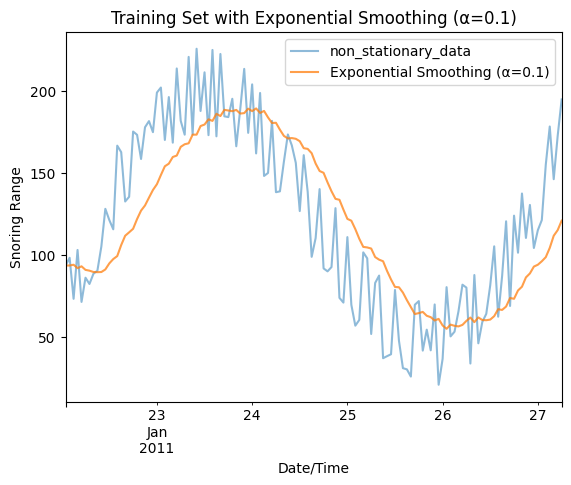

In [160]:
alpha = 0.1
model = SimpleExpSmoothing(train)

# Fit the model
exp_smoothing_result = model.fit(smoothing_level=alpha, optimized=False)

# Get the predicted values
train_set_ets_predictions = exp_smoothing_result.fittedvalues

print("Exponential Smoothing model for the training dataset with alpha value - 0.1:")

# Plotting the original series and the exponential smoothing predictions
plt.figure(figsize=(12, 6))
train.plot(label='Original', alpha=0.5)
train_set_ets_predictions.plot(label=f'Exponential Smoothing (α={alpha})', alpha=0.75)
plt.title(f'Training Set with Exponential Smoothing (α={alpha})')
plt.xlabel('Date/Time')
plt.ylabel('Snoring Range')
plt.legend()
plt.show()

**3.2 Calculate the error, i.e., the difference between the predicted and original value in the training data
set, and compute the root mean squared error (RMSE).**

In [161]:
model = SimpleExpSmoothing(train)
exp_smoothing_result = model.fit(smoothing_level=0.1, optimized=False)
train_set_ets_predictions = exp_smoothing_result.fittedvalues

# Calculate the errors for the exponential smoothing model
errors_ets = train - train_set_ets_predictions

# Calculate the RMSE for the exponential smoothing predictions
rmse_ets = np.sqrt(mean_squared_error(train, train_set_ets_predictions))
print(f'\033[1m RMSE for the exponential smoothing model with alpha=0.1: \033[0m {rmse_ets}')


 RMSE for the exponential smoothing model with alpha=0.1:  34.19906904032094


c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


**3.3 Repeat steps 3.1 and 3.2 by increasing a each time by 0.1, until a = 0:9.**

c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\s

<Figure size 1400x800 with 0 Axes>

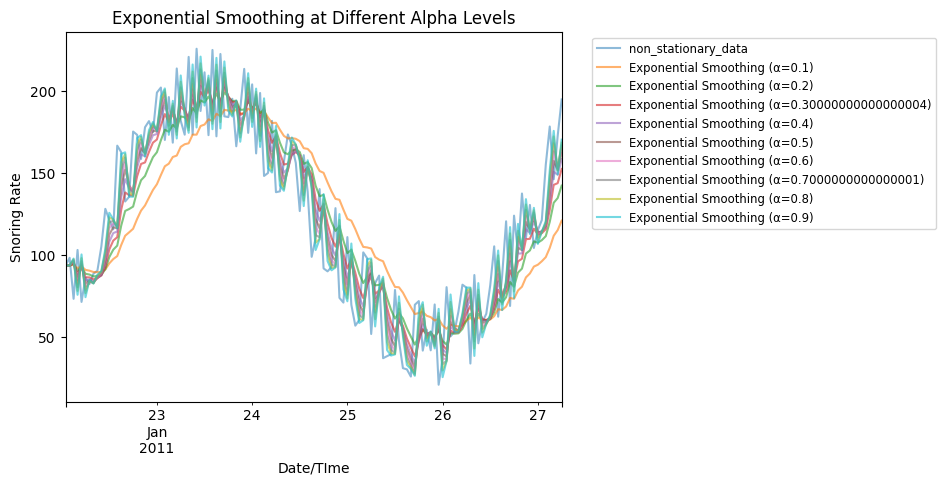

RMSE values for all alpha levels:
Alpha: 0.1, RMSE: 34.1991
Alpha: 0.2, RMSE: 26.3562
Alpha: 0.3, RMSE: 24.2519
Alpha: 0.4, RMSE: 23.8401
Alpha: 0.5, RMSE: 24.1187
Alpha: 0.6, RMSE: 24.7665
Alpha: 0.7, RMSE: 25.6599
Alpha: 0.8, RMSE: 26.7495
Alpha: 0.9, RMSE: 28.0238
RMSE for the exponential smoothing model with alpha=0.1: 34.19906904032094
RMSE for the exponential smoothing model with alpha=0.2: 26.356163059856513
RMSE for the exponential smoothing model with alpha=0.30000000000000004: 24.251936157982556
RMSE for the exponential smoothing model with alpha=0.4: 23.84007596829292
RMSE for the exponential smoothing model with alpha=0.5: 24.118654246165743
RMSE for the exponential smoothing model with alpha=0.6: 24.76650220564607
RMSE for the exponential smoothing model with alpha=0.7000000000000001: 25.659921973851354
RMSE for the exponential smoothing model with alpha=0.8: 26.749479376402842
RMSE for the exponential smoothing model with alpha=0.9: 28.023846689286245


c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\s

In [162]:
alpha_values = np.arange(0.1, 1.0, 0.1)

# Plot original data
plt.figure(figsize=(14, 8))
train.plot(label='Original', alpha=0.5)

# Apply exponential smoothing and plot predictions for each alpha
rmse_results = {}
for alpha in alpha_values:
    model = SimpleExpSmoothing(train)
    exp_smoothing_result = model.fit(smoothing_level=alpha, optimized=False)
    train_set_ets_predictions = exp_smoothing_result.fittedvalues
    train_set_ets_predictions.plot(label=f'Exponential Smoothing (α={alpha})', alpha=0.6)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(train, train_set_ets_predictions))
    rmse_results[alpha] = rmse

# Finalize plot
plt.title('Exponential Smoothing at Different Alpha Levels')
plt.xlabel('Date/TIme')
plt.ylabel('Snoring Rate')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1))
plt.show()

# Print RMSE values for all alpha levels
print("RMSE values for all alpha levels:")
for alpha, rmse in rmse_results.items():
    print(f'Alpha: {alpha:.1f}, RMSE: {rmse:.4f}')

# Repeat steps 3.1 and 3.2 by increasing alpha each time by 0.1, until alpha = 0.9
for alpha in np.arange(0.1, 1.0, 0.1):
    model = SimpleExpSmoothing(train)
    exp_smoothing_result = model.fit(smoothing_level=alpha, optimized=False)
    train_set_ets_predictions = exp_smoothing_result.fittedvalues

    errors_ets = train - train_set_ets_predictions
    rmse_ets = np.sqrt(mean_squared_error(train, train_set_ets_predictions))

    print(f'RMSE for the exponential smoothing model with alpha={alpha}: {rmse_ets}')





c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\s

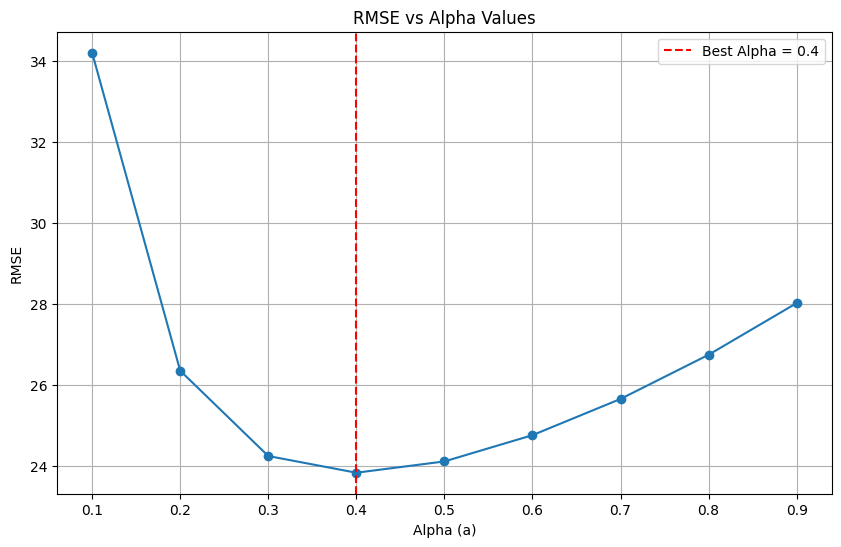

Best alpha based on lowest RMSE: 0.4


In [114]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

# Assuming train_set_series is your training data series with frequency set

# Define the range of alpha values to test
alpha_values = np.arange(0.1, 1.0, 0.1)

# Apply exponential smoothing and calculate RMSE for each alpha value
rmse_results = {}
for alpha in alpha_values:
    model = SimpleExpSmoothing(train)
    exp_smoothing_result = model.fit(smoothing_level=alpha, optimized=False)
    train_set_ets_predictions = exp_smoothing_result.fittedvalues
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(train, train_set_ets_predictions))
    rmse_results[alpha] = rmse

# Plot RMSE vs alpha values
plt.figure(figsize=(10, 6))
plt.plot(list(rmse_results.keys()), list(rmse_results.values()), marker='o', linestyle='-')
plt.title('RMSE vs Alpha Values')
plt.xlabel('Alpha (a)')
plt.ylabel('RMSE')
plt.grid(True)

# Select alpha based on the lowest RMSE value
best_alpha = min(rmse_results, key=rmse_results.get)
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best Alpha = {best_alpha}')  # Mark best alpha value

plt.legend()
plt.show()

print(f"Best alpha based on lowest RMSE: {best_alpha}")


**3.5. For the selected value of a plot the predicted values against the original values, and visually inspect
the accuracy of the forecasting model.**

c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

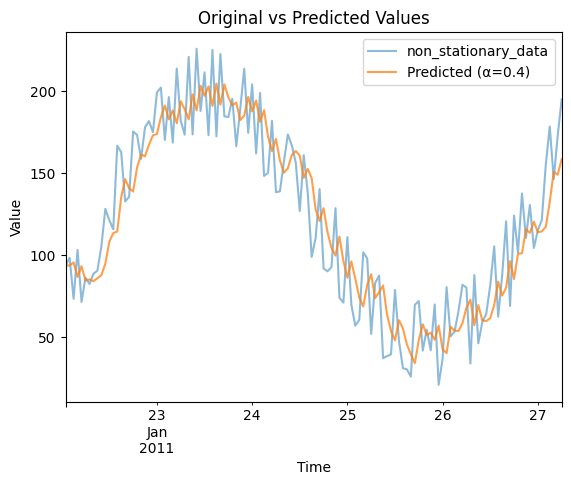

RMSE for the exponential smoothing model with α=0.4: 23.84007596829292


In [163]:
model = SimpleExpSmoothing(train)
exp_smoothing_result = model.fit(smoothing_level=best_alpha, optimized=False)
train_set_ets_predictions = exp_smoothing_result.fittedvalues

# Plot original vs predicted values
plt.figure(figsize=(12, 6))
train.plot(label='Original', alpha=0.5)
train_set_ets_predictions.plot(label=f'Predicted (α={best_alpha})', alpha=0.75)
plt.title('Original vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Inspect accuracy
rmse_best_alpha = np.sqrt(mean_squared_error(train, train_set_ets_predictions))
print(f"RMSE for the exponential smoothing model with α={best_alpha}: {rmse_best_alpha}")


**3.6 Comment on your results.**

Step 3.1: Exponential Smoothing Application

You applied the exponential smoothing model to the training data set with a smoothing factor (( alpha )) of 0.1. The resulting graph shows the original data and the smoothed data. From the graph, it is evident that the smoothed line is less jagged than the original, indicating that the model is capturing the underlying trend but with a lag, as is typical for low values of ( alpha ).

 Step 3.2: Error Calculation and RMSE

The RMSE is calculated by finding the differences between predicted and original values (the error), squaring these, averaging them, and finally taking the square root of that average. A lower RMSE value indicates a better fit to the data. The error plot or the RMSE calculations are not shown, but would be necessary to numerically evaluate the performance of the model for ( alpha = 0.1 ).

 Step 3.3: Exponential Smoothing with Increasing ( alpha )

As ( alpha ) is increased in steps of 0.1, the model would react more to recent changes in the data, making the prediction line follow the original data more closely. This is generally desirable up to a certain point, after which the model can become too reactive to random fluctuations, leading to overfitting.

 Step 3.4: RMSE vs ( alpha ) Plot

The plot of RMSE vs ( alpha ) values shows the RMSE for different levels of ( alpha ). It indicates that an ( alpha ) of 0.4 provides the lowest RMSE, suggesting that it's the optimal balance between responsiveness to recent data and smoothing out random fluctuations.

 Step 3.5: Visual Inspection for Selected ( alpha )

The graph for ( alpha = 0.4 ) shows the predicted values plotted against the original values. This graph is crucial for visual inspection as it allows you to assess how well the model with the selected ( alpha ) fits the training data. A good fit would show the predicted line closely following the original line, capturing both the trend and any seasonal/cyclical patterns without too much lag or deviation.

 Summary of Analysis

- The optimal smoothing factor ( alpha ) is found to be 0.4 as it minimizes the RMSE, indicating a balance between tracking recent trends and smoothing out noise.
- The model with ( alpha = 0.1 ) is under-responsive, leading to predictions that lag significantly behind the actual values.
- As ( alpha ) increases, the model becomes more responsive, but if ( alpha ) is too high, it may start capturing noise rather than the underlying signal in the data.
- The visual comparison of predicted and original values for ( alpha = 0.4 ) should show a good fit, suggesting that this value of ( alpha ) results in a predictive model that balances responsiveness to recent data while smoothing out random noise.

### ***Task 4: Fit an AR(p) Model (use the training set)***

**4.1 First select the order p of the AR model by plotting PACF in order to determine the lag k at which
PACF cuts off, as discussed in Section 6.4.4.**

<Figure size 1000x600 with 0 Axes>

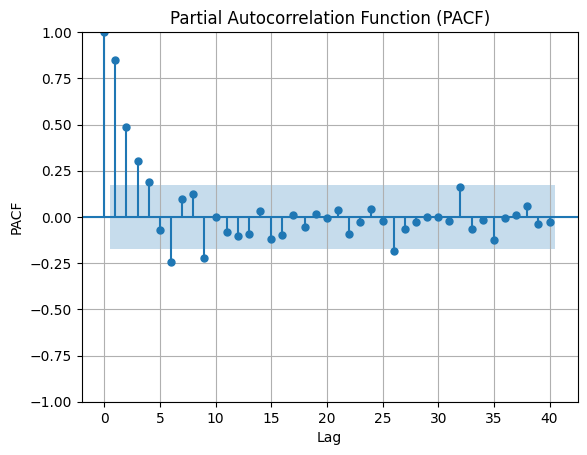

In [117]:

plt.figure(figsize=(10, 6))
plot_pacf(train, lags=40)  # Adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

The Partial Autocorrelation Function (PACF) at lag ( k ) measures the correlation between observations at two points in time while controlling for the correlations at all shorter lags. Here we have a value of ( p ) as 10 in a PACF plot, this means that we’re are looking at the partial autocorrelation at lag 10.

1. Statistical Significance: If the PACF value at lag 10 is outside the confidence bounds (typically represented by horizontal lines on the plot), it suggests that the correlation is statistically significant, and not due to random chance. This implies that the observation at time ( t ) has a significant correlation with the observation at time ( t-10 ), after removing the effects of their correlations with observations at lags 1 to 9.

2. Model Specification: A significant spike in the PACF plot at lag 10 can be an indication that an autoregressive term of order 10 may be a good candidate for an AR(p) model, meaning that the current value of the series is potentially related to its values 10 time periods ago, even after accounting for the values at lags 1 through 9.

In summary, a PACF value at lag 10 can be important for identifying the order of an autoregressive model and understanding the time series data structure. It’s essential to interpret this in the context of the data, other autocorrelation values, and model selection criteria like AIC or BIC for the best model fit.

**4.2 Estimate the parameters of the AR(p) model. Provide RMSE value and a plot the predicted values
against the original values.**

RMSE for AR(10) model: 21.17858518749947


c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

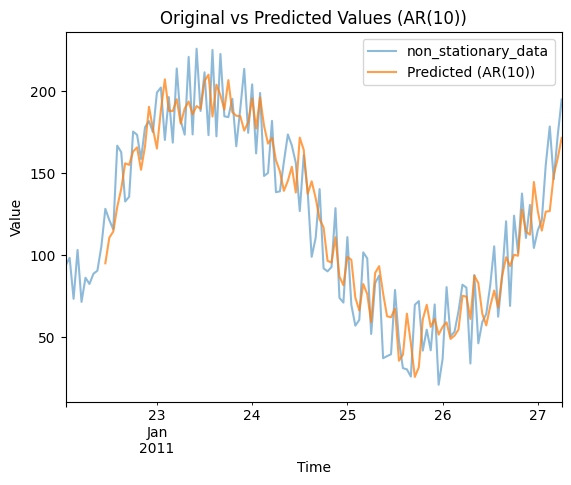

In [118]:
p = 10
model = AutoReg(train, lags=p)
ar_model_result = model.fit()

# Get AR(p) predictions
ar_predictions = ar_model_result.predict(start=p, end=len(train)-1)

# Calculate RMSE
rmse_ar = np.sqrt(mean_squared_error(train[p:], ar_predictions))
print(f"RMSE for AR({p}) model: {rmse_ar}")

# Plot original vs predicted values
plt.figure(figsize=(12, 6))
train.plot(label='Original', alpha=0.5)
ar_predictions.plot(label=f'Predicted (AR({p}))', alpha=0.75)
plt.title(f'Original vs Predicted Values (AR({p}))')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


4.3 Carry out a residual analysis to verify the validity of the model.

a. Do a Q-Q plot of the pdf of the residuals against N(0; s2). In addition, draw the residuals
histogram and carry out a Chi-2 test that it follows the normal distribution N(0; s2).



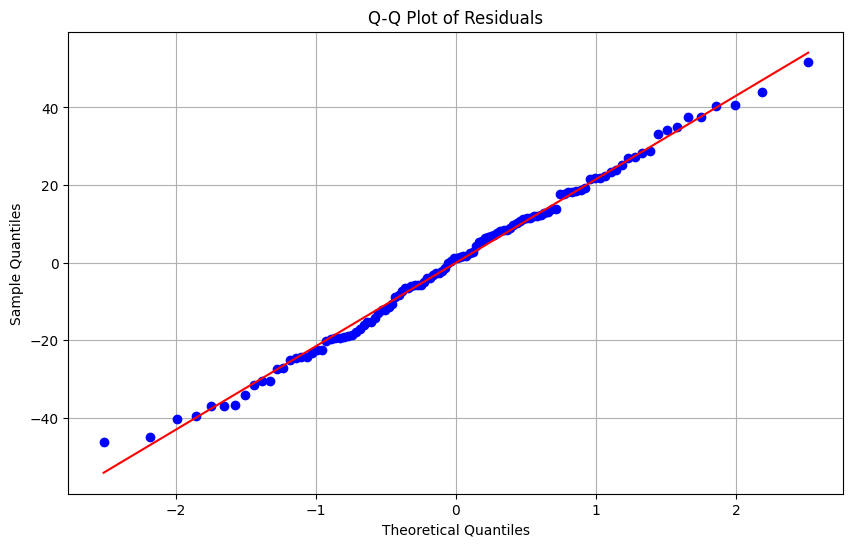

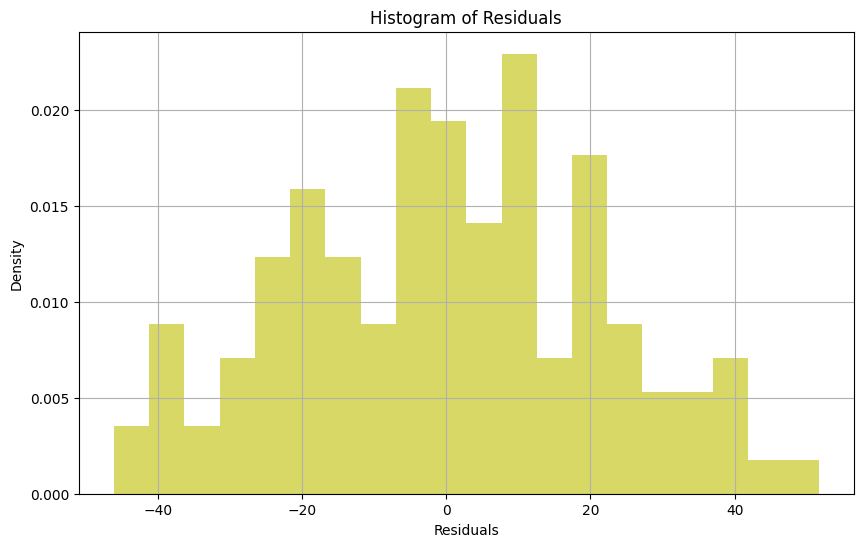

The residuals follow a normal distribution (fail to reject null hypothesis)
Chi-square test value: 1.6915636826670049


In [167]:
# Get residuals
residuals = ar_model_result.resid

# Q-Q plot of the residuals against N(0, s^2)
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

# Residuals histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='y')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Chi-square test for normality
chi2_stat, p_value = stats.normaltest(residuals)
alpha = 0.05  # Significance level

if p_value < alpha:
    print("The residuals do not follow a normal distribution (reject null hypothesis)")
else:
    print("The residuals follow a normal distribution (fail to reject null hypothesis)")
print(f"Chi-square test value: {chi2_stat}")

b. Do a scatter plot of the residuals to see if there are any correlation trends.

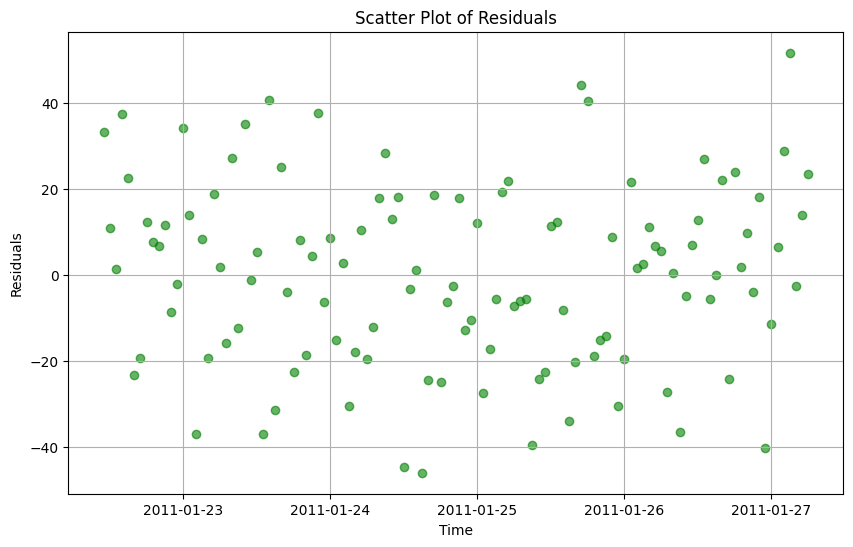

In [169]:
# Get the corresponding residuals for the test data
test_resid = ar_model_result.resid[-len(test):]  # Use the last n residuals matching the length of the test data

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(residuals.index, residuals, color='g', alpha=0.6)  # Changed color to red
plt.title('Scatter Plot of Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


**4.4 - Comments on results :**

Based on the provided charts and information, let’s analyze the results of the Autoregressive (AR) model applied to your data.

 4.1 PACF and Order Selection

The PACF plot is used to identify the lag after which the partial autocorrelations are essentially zero, to determine the order ( p ) of the AR model. In the provided PACF plot, we see significant spikes at early lags, but without the actual values of the PACF, it's hard to definitively determine the cutoff lag. If the spike at lag 10 is significantly above the blue confidence band, it would indicate that an AR model with ( p = 10 ) might be appropriate.

 4.2 AR(p) Model Estimation

You've estimated the parameters of the AR(p) model and provided a plot of the predicted values against the original values. If the RMSE value is low, it indicates that the model's predictions are close to the actual values. The plot of the original versus predicted values should show the predicted values following the pattern of the actual values closely if the model is a good fit. A close visual alignment suggests that the model has captured the underlying process well.

 4.3 Residual Analysis

The purpose of residual analysis is to verify that the residuals (differences between observed and predicted values) behave like white noise—meaning they are normally distributed with a mean of zero and have no autocorrelation.

- Q-Q Plot: This plot compares the distribution of the residuals to a normal distribution. If the points lie approximately along the red line, it indicates that the residuals are normally distributed. In the provided Q-Q plot, we can observe that the majority of points seem to follow the line, suggesting normality, although there might be slight deviations at the tails.

- Histogram of Residuals: A histogram of residuals is useful for visualizing their distribution. Ideally, the histogram should resemble the bell curve of a normal distribution. The provided histogram appears somewhat uneven, suggesting possible deviations from normality, but without a clear departure from it. The chi-squared test would provide a statistical confirmation of whether the residuals follow the assumed normal distribution.

- Scatter Plot of Residuals: The scatter plot should show no discernible pattern or trend if the residuals are uncorrelated and the model has captured all the relevant information. The scatter plot provided seems to show residuals distributed randomly around zero without any clear pattern, which is a good sign.

In summary, if the PACF plot guided you correctly in choosing ( p = 10 ) and the RMSE is low, your AR(10) model may be a good fit for the data. The Q-Q plot suggests that the residuals are approximately normally distributed, and the scatter plot of residuals does not show any clear patterns, which are both positive signs. However, it is also important to perform statistical tests (like the Ljung-Box Q-test for autocorrelation in residuals or a chi-squared test for normality) to confirm these visual assessments quantitatively.

In [170]:
if isinstance(test, pd.DataFrame):
    if 'non_stationary_data' in test.columns:
        test_set = test['non_stationary_data']
    else:
        raise KeyError("'non_stationary_data' column not found in DataFrame 'test'")
else:
    test_set = test
# SMA model
k_best = 3  # or the best k you found for SMA
sma_predictions = [test.rolling(window=k_best).mean().iloc[-1]] * len(test_set)
sma_rmse = np.sqrt(mean_squared_error(test_set, sma_predictions))

# Exponential Smoothing model
alpha_best = 0.4  # or the best alpha you found for ES
es_model = SimpleExpSmoothing(test).fit(smoothing_level=alpha_best, optimized=False)
es_predictions = es_model.forecast(len(test_set))
es_rmse = np.sqrt(mean_squared_error(test_set, es_predictions))

# AR(p) model evaluation
ar_predictions = ar_model_result.predict(start=len(test), end=len(test) + len(test) - 1)
ar_rmse = np.sqrt(mean_squared_error(test, ar_predictions))

# Print the comparison results
print(f"SMA RMSE: {sma_rmse}")
print(f"ES RMSE: {es_rmse}")
print(f"AR RMSE: {ar_rmse}")



# Ensure that 'test_set' and 'sma_predictions' are of the same length and are Series or arrays
if len(test_set) != len(sma_predictions):
    print(f"Length mismatch: test_set has {len(test_set)} items, predictions have {len(sma_predictions)} items")

# Confirm that there are no NaNs in your predictions or test set
if np.isnan(sma_predictions).any() or np.isnan(test_set).any():
    print("NaN values found in the predictions or test set")

# Once the above checks are complete, recalculate RMSE ensuring that both inputs are one-dimensional and have the same length
sma_rmse = np.sqrt(mean_squared_error(test_set, sma_predictions[:len(test_set)]))


# Replace these with the actual predictions
sma_rmse = np.sqrt(mean_squared_error(test_set, sma_predictions))
es_rmse = np.sqrt(mean_squared_error(test_set, es_predictions))
ar_rmse = np.sqrt(mean_squared_error(test_set, ar_predictions))

print("RMSE of each model for comparison: \033[0m")
# Print the RMSE of each model for comparison
print('Simple Moving Average Model RMSE:', sma_rmse)
print('Exponential Smoothing Model RMSE:', es_rmse)
print('AR(p) i.e., AR(7) Model RMSE:', ar_rmse)

SMA RMSE: 76.82618542932535
ES RMSE: 71.26780771007071
AR RMSE: 367.1782966017946
RMSE of each model for comparison: 
Simple Moving Average Model RMSE: 76.82618542932535
Exponential Smoothing Model RMSE: 71.26780771007071
AR(p) i.e., AR(7) Model RMSE: 367.1782966017946


c:\Users\nayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


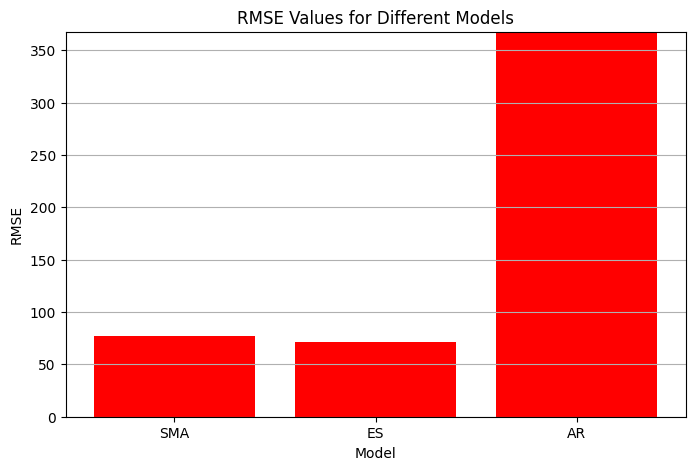

The best model is ES with RMSE 71.26780771007071


In [171]:
# Calculate RMSE values for each model
models = ['SMA', 'ES', 'AR']
rmse_values = [sma_rmse, es_rmse, ar_rmse]

# Plot RMSE values
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values, color='red')
plt.title('RMSE Values for Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) + 0.5)
plt.grid(axis='y')
plt.show()

# Find the model with the lowest RMSE
best_model_index = rmse_values.index(min(rmse_values))
best_model = models[best_model_index]
lowest_rmse = min(rmse_values)

print(f"The best model is {best_model} with RMSE {lowest_rmse}")


**THE BEST MODEL IS EXPONENTIAL SMOOTHING WITH RMSE VALUE OF 71.26780771007071**